## Importing necessary libraries

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np

from datetime import datetime

2025-10-26 20:01:00.495755: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-26 20:01:00.611270: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-10-26 20:01:00.674075: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-10-26 20:01:00.683369: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-10-26 20:01:00.758504: I tensorflow/core/platform/cpu_feature_guar

In [2]:
img_h = 224
img_w = 224
batch_size = 32

In [3]:
train_ds = image_dataset_from_directory("images/data/train",
                                        image_size=(img_h, img_w),
                                        batch_size=batch_size,
                                        label_mode='categorical')

val_ds = image_dataset_from_directory("images/data/val",
                                      image_size=(img_h, img_w),
                                      batch_size=batch_size,
                                      label_mode='categorical')

test_ds = image_dataset_from_directory("images/data/test",
                                       image_size=(img_h, img_w),
                                       batch_size=batch_size,
                                       label_mode='categorical',
                                       shuffle=False)

Found 6225 files belonging to 11 classes.
Found 1092 files belonging to 11 classes.


I0000 00:00:1761489064.076847  165455 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-10-26 20:01:04.304061: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Found 3187 files belonging to 11 classes.


In [4]:
train_ds.class_names

['animal fish',
 'animal fish bass',
 'fish sea_food black_sea_sprat',
 'fish sea_food gilt_head_bream',
 'fish sea_food hourse_mackerel',
 'fish sea_food red_mullet',
 'fish sea_food red_sea_bream',
 'fish sea_food sea_bass',
 'fish sea_food shrimp',
 'fish sea_food striped_red_mullet',
 'fish sea_food trout']

In [5]:
train_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 11), dtype=tf.float32, name=None))>

In [6]:
## Augmenting the training data

augment = Sequential([tf.keras.layers.RandomRotation(0.2),
                      tf.keras.layers.RandomZoom(0.2),
                      tf.keras.layers.RandomFlip("horizontal")])

In [7]:
def prepare(ds, shuffle=False, apply_augment=False):
    ds = ds.map(lambda x, y: (preprocess_input(x), y), num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.cache()
    if shuffle: 
        ds = ds.shuffle(1000) 
    if apply_augment: 
        ds = ds.map(lambda x, y: (augment(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE)
    return ds.prefetch(buffer_size=tf.data.AUTOTUNE)

In [8]:
train_fds = prepare(train_ds, shuffle=True, apply_augment=True)
val_fds = prepare(val_ds)
test_fds = prepare(test_ds)

## Model Training

> **Pre-trained VGG16 Model**

In [9]:
## Loading Base VGG16 Pre-Trained Model

base_model = VGG16(weights='imagenet', # Pre-Training on ImageNet
                   include_top=False,  # Exclude Final Fully Connected Dense Layers to increase feature extraction efficiency
                   input_shape=(img_h, img_w, 3))

In [10]:
## Freezing base model

base_model.trainable = False

In [11]:
base_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [12]:
## Building Layers of Pre-trained Model

inputs = Input(shape=(img_h, img_w, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D() (x) # Summarizing feature maps to vectors
x = Dropout(0.5) (x)
outputs = Dense(train_fds.element_spec[1].shape[-1], activation='softmax') (x)

In [13]:
## Creating a new Pre-trained Model

pre_trained_vgg16 = Model(inputs, outputs)

In [14]:
pre_trained_vgg16.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 11)             │         5,643 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,720,331 (56.15 MB)

 Trainable params: 5,643 (22.04 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

> **Defining Callbacks**

In [15]:
# Callbacks

early_stopping = EarlyStopping(monitor='val_loss',
                               patience=3,
                               restore_best_weights=True,
                               verbose=1)

checkpoint = ModelCheckpoint(filepath='Trained Model/best_vgg16_model_pretune.keras',
                             monitor='val_loss',
                             save_best_only=True,
                             save_weights_only=False,
                             verbose=1)

> **Initial Training Before Fine-tuning**

In [16]:
## Already freezed all layers, so run few epochs and set learning rate

pre_trained_vgg16.compile(optimizer="adam",      ## default learninng_rate = 0.001(1e-3)
                          loss="categorical_crossentropy",
                          metrics=["accuracy"])

bf_vgg16_history = pre_trained_vgg16.fit(train_fds,
                                         validation_data=val_fds,
                                         epochs=5,
                                         callbacks=[early_stopping, checkpoint])

Epoch 1/5


195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2832 - loss: 6.3271
Epoch 1: val_loss improved from None to 0.72596, saving model to Trained Model/best_vgg16_model_pretune.keras
195/195 ━━━━━━━━━━━━━━━━━━━━ 387s 2s/step - accuracy: 0.4260 - loss: 4.0783 - val_accuracy: 0.8223 - val_loss: 0.7260
Epoch 2/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6760 - loss: 1.4933
Epoch 2: val_loss improved from 0.72596 to 0.29935, saving model to Trained Model/best_vgg16_model_pretune.keras
195/195 ━━━━━━━━━━━━━━━━━━━━ 386s 2s/step - accuracy: 0.7173 - loss: 1.2575 - val_accuracy: 0.9286 - val_loss: 0.2994
Epoch 3/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7967 - loss: 0.8204
Epoch 3: val_loss improved from 0.29935 to 0.16036, saving model to Trained Model/best_vgg16_model_pretune.keras
195/195 ━━━━━━━━━━━━━━━━━━━━ 373s 2s/step - accuracy: 0.8153 - loss: 0.7195 - val_accuracy: 0.9478 - val_loss: 0.1604
Epoch 4/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8483

In [17]:
bf_train_accuracy = bf_vgg16_history.history['accuracy']
bf_train_loss = bf_vgg16_history.history['loss']

bf_val_accuracy = bf_vgg16_history.history['val_accuracy']
bf_val_loss = bf_vgg16_history.history['val_loss']

bf_epochs = range(1, len(bf_train_accuracy)+1)

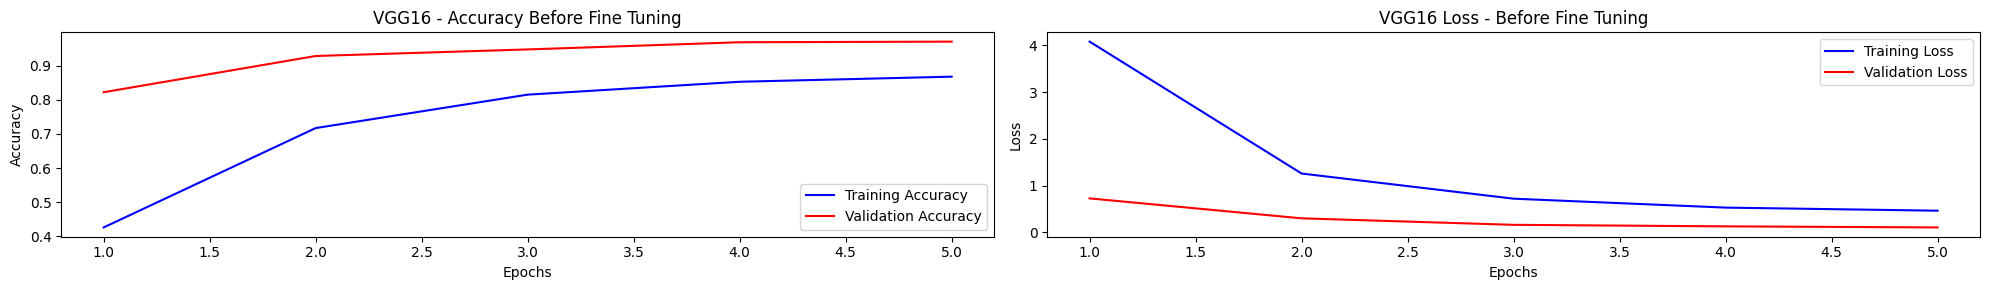

In [18]:
plt.figure(figsize=(20,3))
plt.subplot(1,2,1)
plt.plot(bf_epochs, bf_train_accuracy, 'b-', label='Training Accuracy')
plt.plot(bf_epochs, bf_val_accuracy, 'r-', label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("VGG16 - Accuracy Before Fine Tuning")

plt.subplot(1,2,2)
plt.plot(bf_epochs, bf_train_loss, 'b-', label='Training Loss')
plt.plot(bf_epochs, bf_val_loss, 'r-', label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("VGG16 Loss - Before Fine Tuning")

plt.tight_layout()
plt.show()

In [19]:
pre_trained_vgg16.save('Trained Models/multiclass_fish_before_finetune_pretrained_vgg16_model.keras') ## latest saving method for DL

## Fine-Tuning Pre-Trained VGG16 Model

In [20]:
## Unfreezing Last Covolutional Layers in VGG16

for layer in base_model.layers:
    if layer.name in ['block5_conv1', 'block5_conv2', 'block5_conv3']:
        layer.trainable = True

> **Defining Checkpoint for FineTuned Model**

In [21]:
check_point1 = ModelCheckpoint(filepath="Trained Models/best_vgg16_model_finetuned.keras",
                               monitor="val_loss",
                               save_best_only=True,
                               save_weights_only=False,
                               verbose=1)

In [22]:
## Setting Lesser Learning Rate and Increasing epochs

pre_trained_vgg16.compile(optimizer=Adam(learning_rate=1e-5),
                          loss="categorical_crossentropy",
                          metrics=["accuracy"])

af_vgg16_history = pre_trained_vgg16.fit(train_fds,
                                         validation_data=val_fds,
                                         epochs=10,
                                         callbacks=[early_stopping, check_point1])

Epoch 1/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9090 - loss: 0.2969
Epoch 1: val_loss improved from None to 0.03826, saving model to Trained Models/best_vgg16_model_finetuned.keras
195/195 ━━━━━━━━━━━━━━━━━━━━ 436s 2s/step - accuracy: 0.9263 - loss: 0.2342 - val_accuracy: 0.9899 - val_loss: 0.0383
Epoch 2/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9433 - loss: 0.1705
Epoch 2: val_loss improved from 0.03826 to 0.03582, saving model to Trained Models/best_vgg16_model_finetuned.keras
195/195 ━━━━━━━━━━━━━━━━━━━━ 442s 2s/step - accuracy: 0.9542 - loss: 0.1439 - val_accuracy: 0.9890 - val_loss: 0.0358
Epoch 3/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9655 - loss: 0.1196
Epoch 3: val_loss did not improve from 0.03582
195/195 ━━━━━━━━━━━━━━━━━━━━ 436s 2s/step - accuracy: 0.9700 - loss: 0.1011 - val_accuracy: 0.9918 - val_loss: 0.0394
Epoch 4/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9734 - loss: 0.0801
Epoch 4: val_loss improved fro

In [23]:
af_train_accuracy = af_vgg16_history.history['accuracy']
af_train_loss = af_vgg16_history.history['loss']

af_val_accuracy = af_vgg16_history.history['val_accuracy']
af_val_loss = af_vgg16_history.history['val_loss']

epochs = range(1, len(af_train_accuracy)+1)

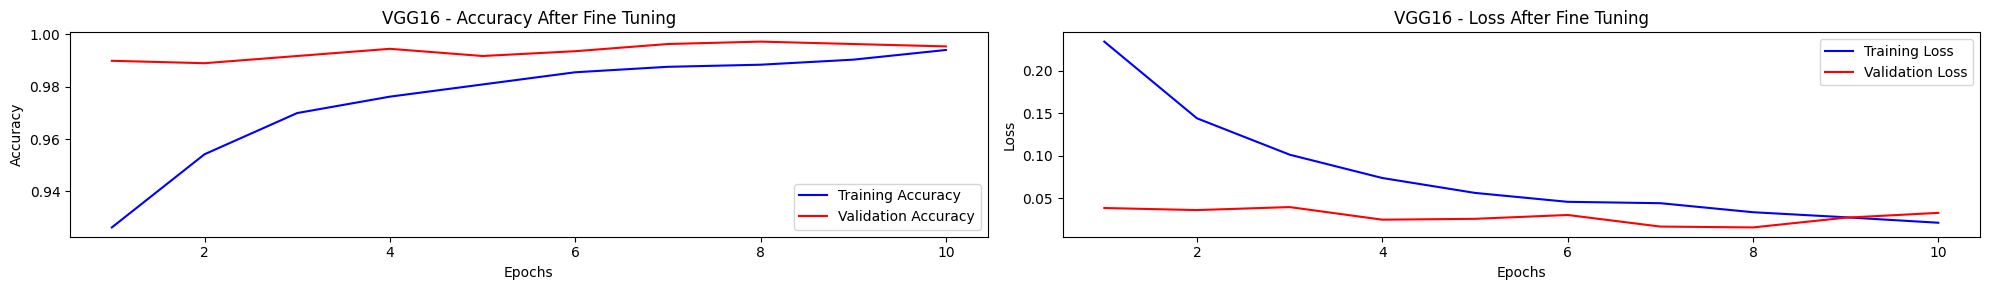

In [24]:
plt.figure(figsize=(20,3))
plt.subplot(1,2,1)
plt.plot(epochs, af_train_accuracy, 'b-', label='Training Accuracy')
plt.plot(epochs, af_val_accuracy, 'r-', label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("VGG16 - Accuracy After Fine Tuning")

plt.subplot(1,2,2)
plt.plot(epochs, af_train_loss, 'b-', label='Training Loss')
plt.plot(epochs, af_val_loss, 'r-', label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("VGG16 - Loss After Fine Tuning")

plt.tight_layout()
plt.show()

> **Saving Pre-Trained Model**

In [25]:
pre_trained_vgg16.save('Trained Models/multiclass_fish_pretrained_vgg16_model.keras') ## latest saving method for DL

## Model Evaluation

> **Model Testing**

In [26]:
# Evaluating model based on accuracy

vgg16_loss, vgg16_accuracy = pre_trained_vgg16.evaluate(test_fds)
vgg16_accuracy

100/100 ━━━━━━━━━━━━━━━━━━━━ 168s 2s/step - accuracy: 0.9984 - loss: 0.0085


0.9984311461448669

> **Finding Prediction Classes and True Classes**

In [27]:
# Getting Predictions Probabilities and Predicted Classes

y_probs = pre_trained_vgg16.predict(test_fds)
y_pred = np.argmax(y_probs, axis=1)

100/100 ━━━━━━━━━━━━━━━━━━━━ 162s 2s/step


In [28]:
## Getting True Classes

y_true_list = []
for _, label_batch in test_ds:
    y_true_list.extend(label_batch.numpy().tolist())
y_true = np.argmax(y_true_list, axis=1)

2025-10-26 21:50:08.205259: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [29]:
print(y_pred.shape)
print(y_true.shape)

(3187,)
(3187,)


> **Performance Metrics**

In [30]:
# Other Performance Metrics Calculations

vgg16_precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
vgg16_recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
vgg16_f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
vgg16_cm = confusion_matrix(y_true, y_pred)

In [31]:
print("VGG16 Model - After Fine Tuning Performance Metrics:\n")
print(f" Accuracy : {vgg16_accuracy*100:.4f}%")
print(f" Loss     : {vgg16_loss:.4f}")
print(f" Precision: {vgg16_precision:.4f}")
print(f" Recall   : {vgg16_recall:.4f}")
print(f" F1 Score : {vgg16_f1:.4f}")

VGG16 Model - After Fine Tuning Performance Metrics:

 Accuracy : 99.8431%
 Loss     : 0.0085
 Precision: 0.9984
 Recall   : 0.9984
 F1 Score : 0.9983


In [32]:
class_indices = {class_name : index for index, class_name in enumerate(test_ds.class_names)}
print(class_indices)

{'animal fish': 0, 'animal fish bass': 1, 'fish sea_food black_sea_sprat': 2, 'fish sea_food gilt_head_bream': 3, 'fish sea_food hourse_mackerel': 4, 'fish sea_food red_mullet': 5, 'fish sea_food red_sea_bream': 6, 'fish sea_food sea_bass': 7, 'fish sea_food shrimp': 8, 'fish sea_food striped_red_mullet': 9, 'fish sea_food trout': 10}


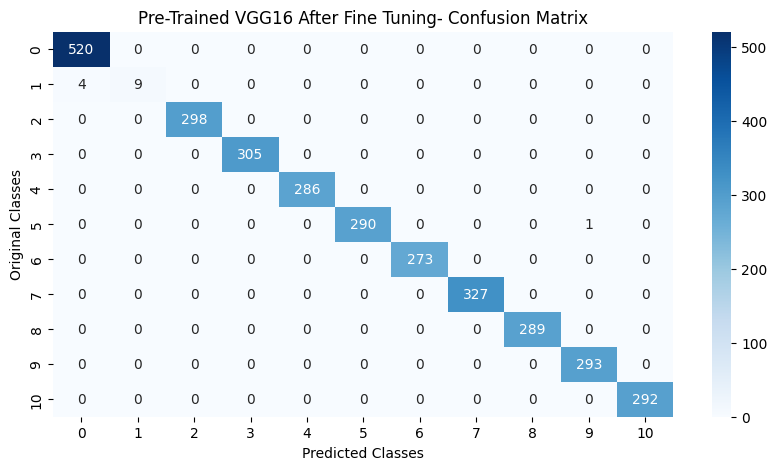

In [33]:
plt.figure(figsize=(10,5))
sns.heatmap(vgg16_cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted Classes")
plt.ylabel("Original Classes")
plt.title("Pre-Trained VGG16 After Fine Tuning- Confusion Matrix")
plt.show()

In [34]:
classes = test_ds.class_names

In [35]:
# Classification Report (per-class)

vgg16_cr = classification_report(y_true, y_pred, target_names=classes, zero_division=0)
print(vgg16_cr)

                                  precision    recall  f1-score   support

                     animal fish       0.99      1.00      1.00       520
                animal fish bass       1.00      0.69      0.82        13
   fish sea_food black_sea_sprat       1.00      1.00      1.00       298
   fish sea_food gilt_head_bream       1.00      1.00      1.00       305
   fish sea_food hourse_mackerel       1.00      1.00      1.00       286
        fish sea_food red_mullet       1.00      1.00      1.00       291
     fish sea_food red_sea_bream       1.00      1.00      1.00       273
          fish sea_food sea_bass       1.00      1.00      1.00       327
            fish sea_food shrimp       1.00      1.00      1.00       289
fish sea_food striped_red_mullet       1.00      1.00      1.00       293
             fish sea_food trout       1.00      1.00      1.00       292

                        accuracy                           1.00      3187
                       macro avg    